# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")


In [3]:
#read the data frame and clearly label the null values in the data frame
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [4]:
churn.tail()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
46202,79494,10,1,61.0,CONSUMER,9,27.27,BYO,7,0,...,NO-CONTRACT,0,OTHER,0,27.27,COUNTRY,VIC,0.0,1.0,0.0
46203,79495,2,1,53.0,CONSUMER,2,54.54,NON BYO,2,0,...,OFF-CONTRACT,24,UNKNOWN,1,54.99,METRO,NSW,NaN,NaN,NaN
46204,79496,47,1,22.0,CONSUMER,47,72.72,NON BYO,7,17,...,ON-CONTRACT,24,APPLE,0,72.72,COUNTRY,NSW,0.0,0.0,0.0
46205,79497,94,1,40.0,CONSUMER,182,17.27,NON BYO,4,0,...,OFF-CONTRACT,24,APPLE,0,17.27,METRO,VIC,0.0,0.0,0.0
46206,79500,0,1,24.0,CONSUMER,0,36.36,BYO,0,0,...,NO-CONTRACT,0,APPLE,0,36.36,METRO,NSW,0.0,0.0,0.0


In [5]:
churn.shape

(46206, 21)

In [6]:
## discover what's in the column of CHUND_IND
CHURN_IND=churn['CHURN_IND']
CHURN_IND
set(CHURN_IND)

{0, 1}

In [7]:
hist(CHURN_IND)

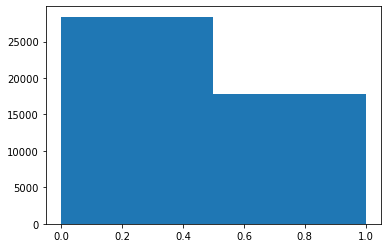

In [8]:
## plot the distribution of churn status of customers
plt.hist(CHURN_IND,bins=2)
plt.show()

In [9]:
num_0=sum(CHURN_IND==0)## non churn, can be kept by the company
num_1=sum(CHURN_IND==1)## churn, lost by the company
print('the number of non-churn:%d'%num_0)

the number of non-churn:28416


In [10]:
## have a general count of the number of customer not churned and churned
class0=churn[churn['CHURN_IND']==0]
print(class0.shape[0])
class1=churn[churn['CHURN_IND']==1]
print(class1.shape[0])

28416
17790


In [11]:
##getting rid of all the categorical data in the data frame

newchurn=churn.drop(columns=['CFU','BYO_PLAN_STATUS','CONTRACT_STATUS','HANDSET_USED_BRAND','COUNTRY_METRO_REGION','STATE'])
newchurn.head(50)
##fill all the null value with 0, in order to fit the data frame using a logistic regression model
newchurn=newchurn.fillna(0)


In [12]:
newchurn.tail()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,
46202,79494,10,1,61.0,9,27.27,7,0,0,0,0,27.27,0.0,1.0,0.0
46203,79495,2,1,53.0,2,54.54,2,0,24,24,1,54.99,0.0,0.0,0.0
46204,79496,47,1,22.0,47,72.72,7,17,24,24,0,72.72,0.0,0.0,0.0
46205,79497,94,1,40.0,182,17.27,4,0,24,24,0,17.27,0.0,0.0,0.0
46206,79500,0,1,24.0,0,36.36,0,0,0,0,0,36.36,0.0,0.0,0.0


In [13]:
newchurn.shape

(46206, 15)

In [14]:
##split the data into two sets, 80% of the data is divided into training set and 20% of data is divided into the testing test
train, test=train_test_split(newchurn, test_size = 0.2, random_state=142)
print(train.shape)
print(test.shape)

(36964, 15)
(9242, 15)


In [15]:
##generate the input values for the training and testing sets for the logistic regression models
X_train = train.drop(['CHURN_IND','CUST_ID' ], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND','CUST_ID'], axis=1)
y_test = test['CHURN_IND']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_train.head())
print(y_train.head())

X_train shape:  (36964, 13)
y_train shape:  (36964,)
X_test shape:  (9242, 13)
y_test shape:  (9242,)
       ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE  SERVICE_TENURE  \
INDEX                                                            
38310              42                  2  47.0              42   
38645              81                  2  67.0              50   
10116              12                  1  24.0              12   
32261              61                  1  26.0               0   
10221              57                  1  37.0              57   

       PLAN_ACCESS_FEE  PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
INDEX                                                               
38310            80.90           42                             0   
38645            54.54            1                             6   
10116            31.81           12                            12   
32261            45.45            0                             0   
10221            54.5

In [16]:
## fit the dataframe into logistic regression model
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [17]:
##predictions on the training and testing sets data 
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)


In [18]:
y_hat_train

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

## Evaluation of the model

In [19]:
##generate the accuracy score for the prediction based on training and testing data

print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training set:  0.7275998268585651
Accuracy score on testing set:  0.7236528889850682


The accuracy scores around 72% to 73%, are relatively good, which means the model is relatively excellent. Two accuracy scores are really close, which means the model is not overfitting.

In [20]:
## generate a confusion matrix based on the prediction using testing set data
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test))

Confusion matrix on test set: 
[[4418 1307]
 [1247 2270]]


In [21]:
#### generate a confusion matrix based on the prediction using training set data

print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_train))

Confusion matrix on train set: 
[[17682  5009]
 [ 5060  9213]]


Having more than 50% of data in the True Positive section means the model is relatively accurate

## Feature selection

In [22]:
## implements Recursive Feature Estimation which removes features one by one,
## evaluating the model each time and selecting the best model for a target number of features
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [23]:
#  evaluation on testing set and the prediction based on testing set data
y_test_hat = rfe.predict(X_test)
print("accuracy score on test set: ", accuracy_score(y_test, y_test_hat))

accuracy score on test set:  0.6837264661328717


In [24]:
#summarize all features of the data set
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 2.000
Column: 1, Selected False, Rank: 5.000
Column: 2, Selected False, Rank: 9.000
Column: 3, Selected False, Rank: 7.000
Column: 4, Selected False, Rank: 6.000
Column: 5, Selected False, Rank: 3.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 8.000
Column: 9, Selected False, Rank: 4.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000


In [25]:
## Increment the number of features one each time
acc_scores = []
for i in range(1,10):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.6194546634927505
Acc on test set using 2 features:  0.6194546634927505
Acc on test set using 3 features:  0.6194546634927505
Acc on test set using 4 features:  0.6814542306859988
Acc on test set using 5 features:  0.6837264661328717
Acc on test set using 6 features:  0.680264012118589
Acc on test set using 7 features:  0.682211642501623
Acc on test set using 8 features:  0.7267907379355117
Acc on test set using 9 features:  0.7268989396234581


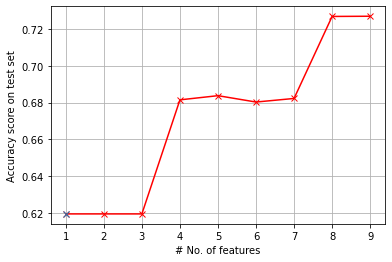

In [28]:
## Estimating the accuracy score on test set using RFE by using different number of features

estimator = LogisticRegression()
acc_scores = []
for i in range(1, 10):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 10), acc_scores, marker = 'x', color = 'red', markeredgewidth = 1 ,markeredgecolor = 'red', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'x', markerfacecolor = 'red')

## Conclusion
The model is relatively precise in predicting the Churn status of Customers. This is evident in terms of the accuracy score, where the model has a high accuracy score of more than 0.7 in both training and testing set. Two accuracy scores values are close, which means the model is not overfitting.
In addition, confusion matrix also suggests that the model is well-performed. The proportion of false positive and false negative in both of the training and testing set are less than 30%, which proves the model to be somewhat accurate in predicting the churn status of customers.